In [1]:
import os
import pymysql
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
np.random.seed(2830)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

<font size=7><b>Section 3: Train Model</b></font>

This notebook trains a LightGBM model using the database `CarMin` and saves it locally.

<br>


This notebook assumes:
* A valid MySQL Server is running.
* The password of 'root'@'localhost' is "insecure_password".
* `Section2_LoadIntoMySQL.sql` has already been run and the database `CarMin` is already created and populated in the MySQL Server.

<br>

Notebook table of contents:
* **Part 1: Complex query to merge all database tables together.**
* **Part 2: Data preparation function for LGBM (reused for Section 4).**
* **Part 3: Get train, validate, and test sets.**
* **Part 4: Train the LGBM model.**
* **Part 5: Test the LGBM model.**
* **Part 6: Feature importance.**

# Part 1: Complex query to merge all database tables together

In [2]:
# connect to MySQL Server -> assumes Section2_LoadIntoMySQL.sql has already been run
# NOTE: For demo purposes, at present, the password for MySQL server on my local machine
#       is temporarily set to "insecure_password"
mysql_connection = pymysql.connect(host="localhost", user="root", password = "insecure_password", db="CarMin") 
cursor = mysql_connection.cursor() 

# complex query to decompress compressed data
sql_get_full_table = """
                     SELECT *
                     FROM Listing
                         LEFT OUTER JOIN (Car LEFT OUTER JOIN MMYT USING (mmyt_id)) USING (vin)
                         LEFT OUTER JOIN Dealer USING (dealer_id);
                     """

# run query through MySQL and store result in pandas dataframe
data_all = pd.read_sql_query(sql_get_full_table, mysql_connection)

# finally, close connection
mysql_connection.close()

# Part 2: Data preparation function for LGBM (reused for Section 4)

In [3]:
def prepare_data_for_lgbm(data, do_validation_split=False, encoder_dict=None):
    """
    Process data generated by join query for modelling with LGBM.
    
    Params:
        data -- data generated by the query:
        
                    SELECT *
                    FROM Listing
                        LEFT OUTER JOIN (Car LEFT OUTER JOIN MMYT USING (mmyt_id)) USING (vin)
                        LEFT OUTER JOIN Dealer USING (dealer_id);
                
                from the MySQL database CarMin
        do_validation_split -- whether to split data into train, validate, and test
        encoder_dict -- the dictionary of LabelEncoders used to encode the categoricals, None means create new
    
    Returns:
        lgb.Dataset objects, three (train/validate/test) if do_validation_split else just one (the whole dataset)
        Also returns the list of LabelEncoders used/created
    """
    # copy data
    data = data.copy()
    
    # ID columns are just a recipe for overfitting -> drop them
    data = data.drop(columns=["dealer_id", "vin", "listing_id", "listing_year", "listing_month",
                              "listing_day", "mmyt_id", "max_horsepower_at_rpm", "max_torque_at_rpm",
                              "trim_name", "mmyt_description", "location", "longitude", "latitude"])
    
    # rename some remaining columns
    data = data.rename(columns={
        "total_listings":"dealer_total_listings",
        "avg_rating":"dealer_avg_rating",
        "zipcode":"dealer_zipcode"
    })
    
    # bring back na-values for LGBM
    data = data.replace({"Unknown":np.nan, -1:np.nan})
    
    # label encode
    categorical_cols = ["is_certified_preowned", "has_accidents", "transmission_type", "exterior_color",
                        "engine_type", "fuel_type", "make_name", "model_name", "body_type", "drivetrain",
                        "dealer_name", "dealer_zipcode", "is_franchise_dealer"]
    if encoder_dict is None:
        encoder_dict = {}
        for categorical_col in categorical_cols:
            encoder = LabelEncoder()
            data[categorical_col] = encoder.fit_transform(data[categorical_col])
            encoder_dict[categorical_col] = encoder
    else:
        for categorical_col in categorical_cols:
            data[categorical_col] = encoder_dict[categorical_col].transform(data[categorical_col])
        
    # split out label
    target = data.price
    data = data.drop(columns=["price"])
       
    # split if do_validation_split (80% train, 10% validate, 10% test)
    if do_validation_split:
        
        # first split
        X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.2,
                                                            shuffle=True, random_state=2830)
        
        # second split
        X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                                  shuffle=True, random_state=2830)
        
        # return three separate lgb.Dataset objects
        train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols,
                            free_raw_data=False, params={"verbose": -1})
        validate = lgb.Dataset(X_validate, label=y_validate, categorical_feature=categorical_cols,
                               free_raw_data=False, params={"verbose": -1})
        test = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_cols,
                           free_raw_data=False, params={"verbose": -1})
        return train, validate, test, encoder_dict
    
    # otherwise just return one lgb.Dataset object
    dataset = lgb.Dataset(data, label=target, categorical_feature=categorical_cols,
                          free_raw_data=False, params={"verbose": -1})
    return dataset, encoder_dict

# Part 3: Get train, validate, and test sets

In [4]:
dataset_train, dataset_validate, dataset_test, encoder_dict = prepare_data_for_lgbm(data_all,
                                                                                    do_validation_split=True,
                                                                                    encoder_dict=None)
# pickle the encoder_dict
pickle_file = open("./Models/encoder_dict.pickle", "wb")
pickle.dump(encoder_dict, pickle_file)                    
pickle_file.close()

# Part 4: Train the LGBM model

In [5]:
lgb_params = {
    "objective":"regression",
    "boosting":"gbdt",
    "learning_rate":0.15,
    "num_leaves":64,
    "seed":2830,
    "max_depth":-1, # note LGBM grows leaf-wise
    "min_data_in_leaf":40,
    "metric":"rmse",
    "verbose": -1
}
num_iterations = 4000
lgb_model = lgb.train(lgb_params, dataset_train, num_iterations,
                      valid_sets=[dataset_validate], verbose_eval=False)
lgb_model.save_model("./Models/MODEL_LGBM.txt")

# Part 5: Test the LGBM model

In [6]:
test_predictions = lgb_model.predict(dataset_test.data)
mean_absolute_error(dataset_test.label, test_predictions)

1894.736908745002

Not bad! Dealers frequency mark cars up/down completely arbitrarily by more than 2k!

# Part 6: Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

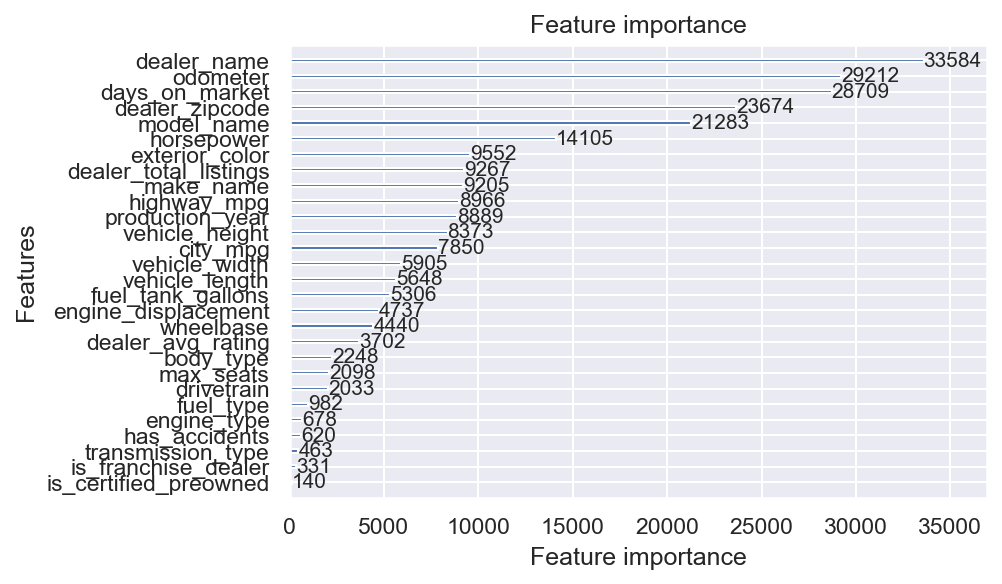

In [8]:
plt.rcParams['figure.dpi'] = 150
lgb.plot_importance(lgb_model)